In [4]:
#More Dynamic Feature-Based Prediction
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime, timedelta

In [5]:
# Function to calculate MACD and Signal Line
def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    data['Short_EMA'] = data['Close'].ewm(span=short_window, adjust=False).mean()
    data['Long_EMA'] = data['Close'].ewm(span=long_window, adjust=False).mean()
    data['MACD'] = data['Short_EMA'] - data['Long_EMA']
    data['Signal_Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()
    return data

In [6]:
# Function to calculate RSI
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))
    return data

In [7]:
# Function to calculate Bollinger Bands
def calculate_bollinger_bands(data, window=20):
    data['SMA'] = data['Close'].rolling(window=window).mean()
    data['Upper_Band'] = data['SMA'] + 2 * data['Close'].rolling(window=window).std()
    data['Lower_Band'] = data['SMA'] - 2 * data['Close'].rolling(window=window).std()
    return data

In [8]:
# Get user inputs
stock_symbol = input("Enter the stock symbol: ").upper()
days_to_use = int(input("Enter the number of days to use for training: "))

print(f"Fetching data for {stock_symbol}...\n")

Fetching data for TSLA...



In [9]:
# Fetch stock data
end_date = datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.now() - timedelta(days=days_to_use)).strftime('%Y-%m-%d')

try:
    stock_data = yf.Ticker(stock_symbol)
    hist_data = stock_data.history(start=start_date, end=end_date)
    hist_data.reset_index(inplace=True)
except Exception as e:
    print("Error fetching stock data. Please check the stock symbol.")
    print(e)
    exit()

In [10]:
# Calculate indicators
hist_data = calculate_macd(hist_data)
hist_data = calculate_rsi(hist_data)
hist_data = calculate_bollinger_bands(hist_data)

In [11]:
# Drop NaN values resulting from indicator calculations
hist_data = hist_data.dropna()

In [12]:
# Prepare the data
hist_data["Days"] = (hist_data["Date"] - hist_data["Date"].min()).dt.days
X = hist_data[["Days", "MACD", "RSI", "Volume", "Upper_Band", "Lower_Band"]].values
y = hist_data["Close"].values

In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Train Random Forest Regression model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [15]:
# Predict and evaluate
y_pred = model.predict(X_test)

In [16]:
# Calculate Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"Model Evaluation Metrics:")
print(f"  - RMSE (Root Mean Square Error): {rmse:.2f}")
print(f"  - MAE (Mean Absolute Error): {mae:.2f}")
print(f"  - R² (R-squared Score): {r2:.2f}")
print(f"  - MAPE (Mean Absolute Percentage Error): {mape:.2f}%")

Model Evaluation Metrics:
  - RMSE (Root Mean Square Error): 11.59
  - MAE (Mean Absolute Error): 8.90
  - R² (R-squared Score): 0.97
  - MAPE (Mean Absolute Percentage Error): 2.85%


In [17]:
# Dynamic feature extrapolation for the next 30 days
future_days = np.arange(hist_data["Days"].max() + 1, hist_data["Days"].max() + 31).reshape(-1, 1)
recent_data = hist_data.tail(30)  # Use the last 30 days for extrapolation
future_features = []

for day in range(1, 31):
    recent_macd = recent_data["MACD"].iloc[-1] + (recent_data["MACD"].diff().mean() * day)
    recent_rsi = recent_data["RSI"].iloc[-1] + (recent_data["RSI"].diff().mean() * day)
    recent_volume = recent_data["Volume"].iloc[-1] + (recent_data["Volume"].diff().mean() * day)
    recent_upper_band = recent_data["Upper_Band"].iloc[-1] + (recent_data["Upper_Band"].diff().mean() * day)
    recent_lower_band = recent_data["Lower_Band"].iloc[-1] + (recent_data["Lower_Band"].diff().mean() * day)
    future_features.append([future_days[day - 1][0], recent_macd, recent_rsi, recent_volume, recent_upper_band, recent_lower_band])

future_features = np.array(future_features)
future_prices = model.predict(future_features)

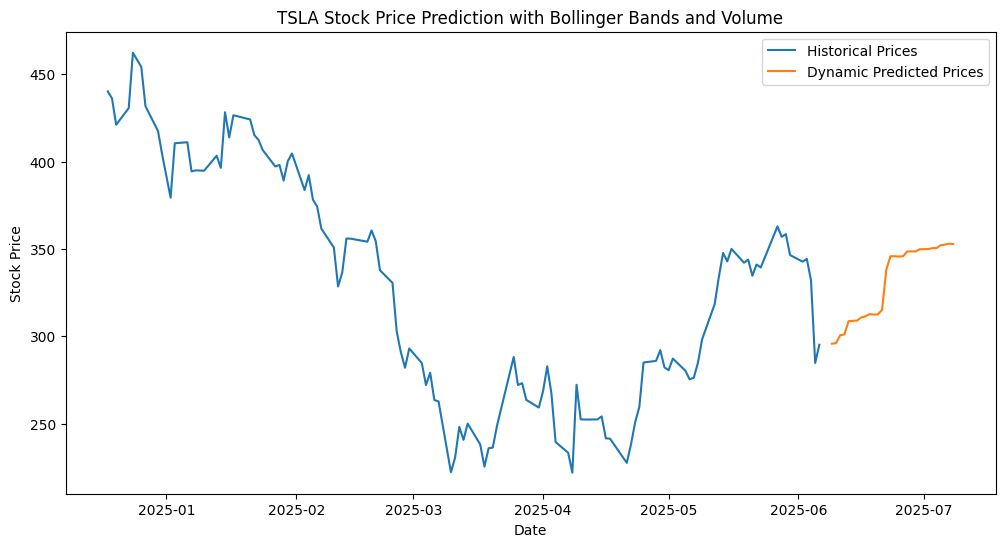

In [ ]:
# Graph
plt.figure(figsize=(12, 6))
plt.plot(hist_data["Date"], hist_data["Close"], label="Historical Prices")
future_dates = [datetime.now() + timedelta(days=i) for i in range(1, 31)]
plt.plot(future_dates, future_prices, label="Dynamic Predicted Prices")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title(f"{stock_symbol} Stock Price Prediction with Bollinger Bands and Volume")
plt.legend()
plt.show()

In [19]:
# Display prediction summary
predicted_price = future_prices[-1]
print(f"\nPredicted price in 30 days: ${predicted_price:.2f}")


Predicted price in 30 days: $352.75
